## Feature Relevance analysis

In [1]:
import sys
import os
import time
import multiprocessing
import pprint 

from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from Packages.NoveltyDetection.setup.noveltyDetectionConfig import CONFIG
from NNNoveltyDetectionAnalysis import NNNoveltyDetectionAnalysis
from Functions.telegrambot import Bot

num_processes = multiprocessing.cpu_count()

from Functions.telegrambot import Bot

my_bot = Bot("lisa_thebot")

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']

training_params = {
    "Technique": "NeuralNetwork",
    "DevelopmentMode": False,
    "DevelopmentEvents": 300,
}
analysis = NNNoveltyDetectionAnalysis(parameters=training_params, 
                                      model_hash="d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198",#"288861ff98f11a0dc05b9fbd92375a80a22fe13671458441e5adc5cd38eea319", 
                                      load_hash=True, load_data=True, verbose=True)
all_data, all_trgt, all_trgt_sparse = analysis.getData()

trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

models = analysis.models

Using TensorFlow backend.


Reading from /home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/outputs/d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198/parameters.json
[+] Time to read data file: 0.9474983215332031 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events
Total of events in the dataset is 77561
Balacing data...
DataHandler Class: CreateEventsForClass
Original Size: (12939, 400)
DataHandler Class: CreateEventsForClass
Original Size: (29352, 400)
DataHandler Class: CreateEventsForClass
Original Size: (11510, 400)
DataHandler Class: CreateEventsForClass
Original Size: (23760, 400)
Reading from /home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/4_folds_cross_validation_balanced_data.jbl
Reading from /home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/4_folds_cross_validation_balanced_data.jbl
Instructions for updating:
Coloc

In [2]:
pp = pprint.PrettyPrinter(indent=1)
print(analysis.model_hash)
print(analysis.getBaseResultsPath())
pp.pprint(analysis.parameters)

d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198
/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/outputs/d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198
{'DevelopmentEvents': 1600,
 'DevelopmentMode': False,
 'HyperParameters': {'batch_size': 128,
                     'classifier_output_activation_function': 'softmax',
                     'dropout': False,
                     'dropout_parameter': 0.0,
                     'hidden_activation_function': 'tanh',
                     'kernel_initializer': 'uniform',
                     'loss': 'mean_squared_error',
                     'metrics': ['accuracy'],
                     'n_epochs': 300,
                     'n_folds': 4,
                     'n_inits': 2,
                     'norm': 'mapstd',
                     'regularization': None,
                     'regularization_parameter': 0.0},
 'InputDataConfig': {'balance_data': True,
                    

### Relevance analysis based on suppressing features and evaluating the performance of the model

In [3]:
from sklearn import preprocessing
from sklearn.externals import joblib

from Functions.sp_index import sp_index

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = [50]

inovelty = 0

# step = 5
# neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
# neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

neurons_str = models[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
# analysis_name = 'feature_relevance_analysis_{}_layer_{}'.format(layer, neurons_str)
analysis_name = 'feature_relevance_analysis_filled_with_mean_{}_layer_{}'.format(layer, neurons_str)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")    

verbose = True

n_bins = all_data.shape[1]
sp_per_bin = np.zeros((len(analysis.class_labels),analysis.n_folds,n_bins))
reference_sp = np.zeros((len(analysis.class_labels),analysis.n_folds))

if not os.path.exists(analysis_file):
    for inovelty in range(len(analysis.class_labels)):
        print("Novelty Class: {}".format(analysis.class_labels[inovelty]))
        for ifold in range(analysis.n_folds):
            print("Fold: {}".format(ifold))
            train_id, test_id = analysis.CVO[inovelty][ifold]

            # normalize known classes
            if analysis.parameters["HyperParameters"]["norm"] == "mapstd":
                scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif analysis.parameters["HyperParameters"]["norm"] == "mapstd_rob":
                scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
            elif analysis.parameters["HyperParameters"]["norm"] == "mapminmax":
                scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])

            known_data = scaler.transform(analysis.trn_data[inovelty][test_id,:])
            known_target = analysis.trn_trgt[inovelty][test_id]
            
            #Import model
            print("Loading model...")
            classifier = models[inovelty].get_model(data  = analysis.trn_data[inovelty],
                                                    trgt  = analysis.trn_trgt[inovelty], 
                                                    hidden_neurons = hidden_neurons[:layer],
                                                    layer = layer,
                                                    ifold = ifold
                                                   )
            
            print("Classifier loaded with success.")
            
            output = classifier.predict(known_data)
            reference_sp[inovelty, ifold] =  sp_index(known_target, np.argmax(output, axis=1))
            
            for ibin in range(n_bins):
                print('%i '%ibin, end='')
                temp_known_data = np.copy(known_data)
                temp_known_data[:,ibin] = np.mean(known_data[:,ibin])
                #Get model output
                output = classifier.predict(temp_known_data)
                #Get SP
                sp_per_bin[inovelty, ifold, ibin] = sp_index(known_target, np.argmax(output, axis=1))
    joblib.dump([reference_sp, sp_per_bin],analysis_file,compress=9)
    my_bot.sendMessage("Got SP for relevance analysis!")
else: 
    reference_sp, sp_per_bin = joblib.load(analysis_file)

/home/vinicius.mello/anaconda3/envs/condaSonar/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


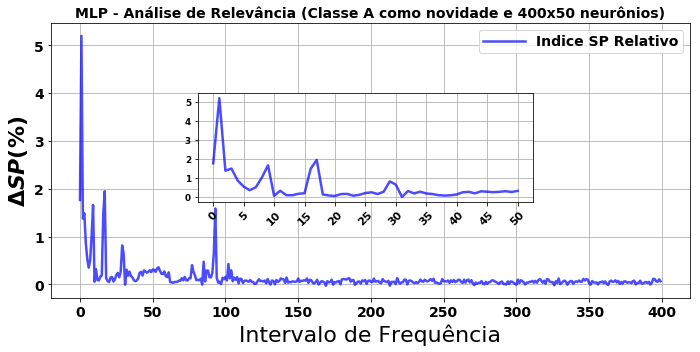

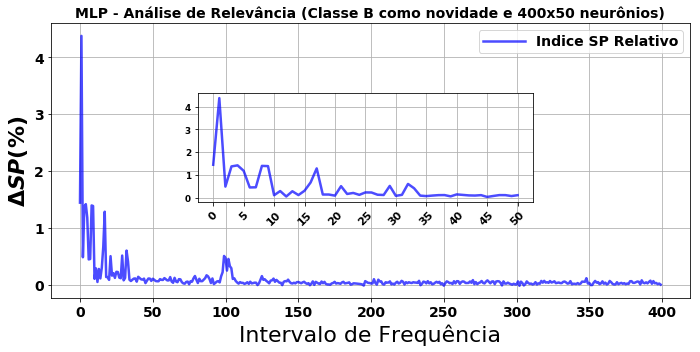

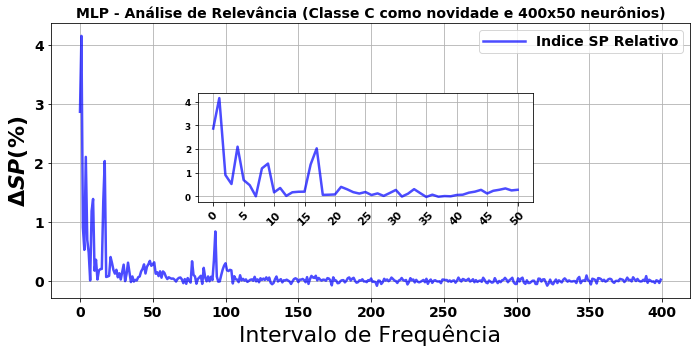

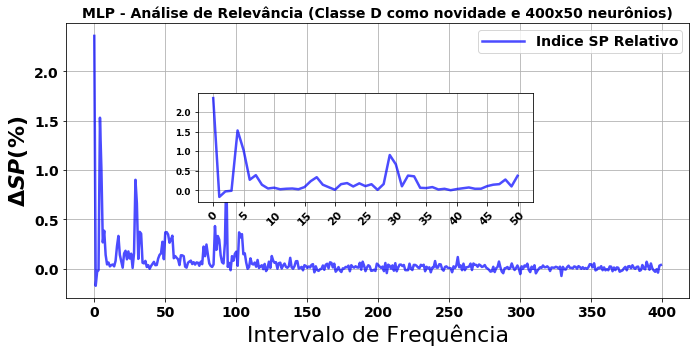

In [4]:
%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from Functions import FunctionsDataVisualization

# Plot 
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)

relevance_features = {}

def meth_agn_v2(x, thresh):
    idx, = np.where(x > thresh)
    return idx[np.argsort(x[idx])][::-1]

for inovelty in range(len(analysis.class_labels)):
    # Plot results    
    fig = plt.subplots(figsize=figsize)
    ax = plt.subplot(1,1,1)
    
    reference_mean_sp = np.mean(reference_sp[inovelty,:], axis=0)
    mean_sp = np.mean(sp_per_bin[inovelty,:], axis=0)
    error_sp = np.std(sp_per_bin[inovelty,:,:], axis=0)
    
#     relative_sp = ((mean_sp-(np.ones(mean_sp.shape)*reference_mean_sp))/reference_mean_sp)*100
    
    relative_sp = (((np.ones(mean_sp.shape)*reference_mean_sp)-mean_sp)/reference_mean_sp)*100

    relevance_features[analysis.class_labels[inovelty]] = {}
    
    relevance_features[analysis.class_labels[inovelty]]['all'] = meth_agn_v2(relative_sp, 0.01) # DeltaSP Positivo
    relevance_features[analysis.class_labels[inovelty]]['tight'] = meth_agn_v2(relative_sp, 0.75*relative_sp.max()) # DeltaSP acima de 75% do valor maximo
    relevance_features[analysis.class_labels[inovelty]]['medium'] = meth_agn_v2(relative_sp, 0.5*relative_sp.max()) # DeltaSP acima de 50% do valor maximo
    relevance_features[analysis.class_labels[inovelty]]['loose'] = meth_agn_v2(relative_sp, 0.25*relative_sp.max()) # DeltaSP acima de 25% do valor maximo
    relevance_features[analysis.class_labels[inovelty]]['veryloose'] = meth_agn_v2(relative_sp, 0.1*relative_sp.max()) # DeltaSP acima de 10% do valor maximo
    
    bins = np.round(np.arange(0,all_data.shape[1],1),3)
    
    ax.plot(bins, relative_sp, color='b', alpha=0.7, linewidth=2.5, label='Indice SP Relativo')
    
#     ax.fill_between(bins, error_sp*100/reference_mean_sp, -error_sp*100/reference_mean_sp, facecolor='blue', alpha=0.3)
    
    ax.set_title('MLP - Análise de Relevância (Classe {} como novidade e {} neurônios)'.format(analysis.class_labels[inovelty], neurons_str),
                                  fontsize=14, fontweight='bold')
    ax.set_ylabel('$\Delta SP (\%)$', fontsize=22)
    ax.set_xlabel('Intervalo de Frequência', fontsize=22)
    ax.grid()
    ax.legend()
    
    rect = [0.2, 0.4, 0.6, 0.4]
    ax1 = FunctionsDataVisualization.add_subplot_axes(ax,rect)
    min_bin = 0
    max_bin = 50
    a = bins >= min_bin
    b = bins <= max_bin
    selected_bins = a & b

    ax1.plot(bins[selected_bins], relative_sp[selected_bins], color='b', alpha=0.7, linewidth=2.5, label='SP Relativo')
    step = 5
    x_ticks = np.arange(min_bin,max_bin+step,step)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticks, rotation=45, fontsize=22)

    ax1.grid()

    plt.tight_layout()
    #Save the figure
    neurons_str = models[inovelty].get_neurons_str(trn_data[inovelty],hidden_neurons=hidden_neurons)
    file_name = os.path.join(analysis.pictures_output_folder, analysis_name+"_{}_novelty_{}_neurons.png".format(inovelty,neurons_str))
    plt.savefig(file_name, format="png")
#     try: 
#         my_bot.sendMessage(imgPath=file_name)
#     except Exception as e:
#         print("Error when sending the image to the bot. Error: {}".format(str(e)))


In [5]:
analysis_file

'/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/outputs/d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198/AnalysisFiles/feature_relevance_analysis_filled_with_mean_1_layer_400x50.jbl'

In [6]:
signal_bins=[]
noise_bins=[]
for ibin in range(400):
    if ibin in relevance_features['A']['loose']:
        signal_bins.append(ibin)
    else:
        noise_bins.append(ibin)


In [7]:
relative_sp[meth_agn_v2(relative_sp, -0.05)]

array([ 2.35784409e+00,  1.52963359e+00,  1.01877971e+00,  9.71849988e-01,
        9.01178970e-01,  6.62404200e-01,  4.32891073e-01,  3.85753123e-01,
        3.74461323e-01,  3.71516167e-01,  3.68797367e-01,  3.68765985e-01,
        3.55931579e-01,  3.51087525e-01,  3.47667807e-01,  3.35323554e-01,
        3.33130683e-01,  3.32143728e-01,  3.17752427e-01,  2.97748753e-01,
        2.95447567e-01,  2.73709199e-01,  2.67634061e-01,  2.64239567e-01,
        2.59267948e-01,  2.46138938e-01,  2.29714770e-01,  2.25327792e-01,
        1.92236754e-01,  1.82874534e-01,  1.76129904e-01,  1.74174300e-01,
        1.58211639e-01,  1.56731898e-01,  1.55793741e-01,  1.55114042e-01,
        1.53407644e-01,  1.51507875e-01,  1.48062359e-01,  1.44144003e-01,
        1.41289802e-01,  1.41133744e-01,  1.40635929e-01,  1.37230620e-01,
        1.37074392e-01,  1.36211029e-01,  1.29650127e-01,  1.28774792e-01,
        1.28308308e-01,  1.28080074e-01,  1.27683710e-01,  1.19405031e-01,
        1.11485597e-01,  

In [8]:
import pandas as pd

from sklearn.externals import joblib

analysis_name = 'relevance_features_results_filled_with_mean_{}_layer_{}'.format(layer, neurons_str)
analysis_file = os.path.join(analysis.getBaseResultsPath(), "AnalysisFiles", analysis_name + ".jbl")   

joblib.dump([relevance_features], analysis_file, compress=9)

['/home/vinicius.mello/Workspace/LPS/SonarAnalysis/Results/NoveltyDetection/NeuralNetwork/outputs/d7175ec280d30121856e19c075f00e5c48b862c9397484062d6c2612256f8198/AnalysisFiles/relevance_features_results_filled_with_mean_1_layer_400x50.jbl']

In [ ]:
x = np.zeros(1000, dtype=object)

for i in range(200):
    x[i] = all_data.copy()
